In [8]:
# import uproot
# import glob
# from tqdm import tqdm
import os, sys
import json
import pickle
import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics

## user define
sys.path.append(".")
sys.path.append("./Utils")
from Plotter import HistStack

channel="mm"


# Set config

In [9]:
setting={}
with open('config/Settrain.json') as json_file:
    data = json.load(json_file)
    setting=data
INPUTDIR = setting["INPUTDIR"]
VERSION = setting["VERSION"]
# SIGNAL_MASSES = ["Zp-1700_CH-345", "Zp-2900_CH-345", "Zp-4100_CH-345", "Zp-2900_CH-1095", "Zp-4100_CH-1095", "Zp-4100_CH-1845"]
CHANNEL="mm"
ERA="mm17"
import sys
INPUTDIR = sys.argv[1]

# Load data

In [10]:
# INPUTDIR = '/eos/user/h/hkwon/Run2/Preselection/20230301/Presel/mm17'
# INPUTDIR = '/eos/user/h/hkwon/SWAN_projects/Zpeak/20230301_17/Presel'
with open(INPUTDIR+'/nested_dic_df_PT.pkl', 'rb') as f: # gitlab CI/CD
# with open(INPUTDIR+'/'+ERA+'/nested_dic_df_PT.pkl', 'rb') as f:
# with open(INPUTDIR+'/'+ERA+'/nested_dic_df_Beq0.pkl', 'rb') as f:
    nested_dic_df = pickle.load(f)  
dic_df=nested_dic_df['raw']
dic_df_met_u_unsort=nested_dic_df['met_u']
dic_df_met_d_unsort=nested_dic_df['met_d'] 

# with open('dic_df_em17.pkl', 'rb') as f:
#     dic_df1 = pickle.load(f)

selected_columns = [
#                     'MC1C1_pre', 'H3PP_pre', 'H3TPP_pre', 
                    'pt_lead_pre', 'mass_pre', # by auc rank
                    'MT_pre', 'pt_trail_pre', 'Zpt_pre', 'dRll_pre', 'PuppiMET_pre',
                    'dPhilMET_pre', 'dPhillMET_pre', 'U_pre', 'dPhill_pre', 'MT2_pre',
                    'JZB_pre'] # order used in training

# # dic_df_meta={}
# # check b jet
# query_str="nbjet_pre==0"

# print("####################################################")
# print("####   (unweighted) #events after preselection  ####")
# print("####################################################")
# for key in dic_df:  
# #     dic_df_meta[key]=dic_df[key].query(query_str)
#     dic_df[key]=dic_df[key].query(query_str) #temp!
#     print(key, ":", dic_df[key].shape[0])
    
dic_df_train={}    
dic_df_met_u={}
dic_df_met_d={}
for key in dic_df:
    #dic_df_train[key]=pd.concat([dic_df[key][selected_columns], dic_df1[key][selected_columns]]) #when use ll channel
    #dic_df[key]=pd.concat([dic_df[key], dic_df1[key]])
#     dic_df_train[key]=dic_df_meta[key][selected_columns] # check b jet   
    dic_df_train[key]=dic_df[key][selected_columns]    
    dic_df_met_u[key]=dic_df_met_u_unsort[key][selected_columns]    
    dic_df_met_d[key]=dic_df_met_d_unsort[key][selected_columns]

In [5]:
print(dic_df["Zp-2500_CH-345"].columns)
print(dic_df_train["Zp-2500_CH-345"].columns)
print(dic_df_met_u["Zp-2500_CH-345"].columns)
# print(dic_df_met_u_sort["TT"].columns)
# print(dic_df_met_d_sort["TT"].columns)

Index(['PuppiMET_pre', 'mass_pre', 'pt_lead_pre', 'pt_trail_pre', 'U_pre',
       'JZB_pre', 'dPhill_pre', 'dPhilMET_pre', 'MT_pre', 'MT2_pre', 'Zpt_pre',
       'dRll_pre', 'dPhillMET_pre', 'MET_pre', 'MET_phi_pre',
       'PuppiMET_phi_pre', 'eta_lead_pre', 'eta_trail_pre', 'phi_lead_pre',
       'phi_trail_pre', 'njet_pre', 'nbjetflav_pre', 'genweight_u_pre',
       'genweight_d_pre', 'genweight_pre', 'puweight_pre', 'puweight_u_pre',
       'puweight_d_pre', 'l1prefiring_pre', 'l1prefiring_u_pre',
       'l1prefiring_d_pre', 'effSF_pre', 'effSF_u_pre', 'effSF_d_pre',
       'topSF_pre', 'topSF_u_pre', 'topSF_d_pre', 'btagSF_pre', 'weight',
       'wopu', 'wol1', 'woeff', 'wotop', 'wobsf', 'weightpuweightUp',
       'weightpuweightDown', 'weightl1prefiringUp', 'weightl1prefiringDown',
       'weighteffSFUp', 'weighteffSFDown', 'weighttopSFUp', 'weighttopSFDown',
       'weightgenweightUp', 'weightgenweightDown'],
      dtype='object')
Index(['pt_lead_pre', 'mass_pre', 'MT_pre', 'pt_

In [5]:
def get_x(sig_key, dic_df_train):
    # x: sig and all bkgs concatenated
    x = dic_df_train[sig_key].copy(deep=True)
    for k in dic_df_train:
        # filter data out
        if "Data" in k:
            continue
        if "Zp" not in k:
            x = np.concatenate([x, dic_df_train[k]], axis=0)
    
    return x

In [6]:
def get_xy(sig_key, dic_predict_sort):
    # x: sig and all bkgs concatenated
    x = dic_predict_sort[sig_key].copy(deep=True)
    for k in dic_predict_sort:
        # filter data out
        if "Data" in k:
            continue
        if "Zp" not in k:
            x = np.concatenate([x, dic_predict_sort[k]], axis=0)
            
    tot_sig = dic_predict_sort[sig_key].shape[0]
    tot_bkgs = x.shape[0] - tot_sig        
    y_sig = np.full((tot_sig,1), 1)
    y_bkgs = np.full((tot_bkgs,1), 0) 
    y = np.concatenate((y_sig, y_bkgs), axis=0) 
    
    return x, y

In [7]:
import math
sys_list = ["puweight", "l1prefiring", "effSF", "topSF"]
# sys_list = ["l1prefiring"]

def draw_with_systematics(dic_df_raw, sys_list, variable, r, region):
    dic_sys = {}
    dic_sys_sqr = {}
    # nominal weight plot
    file_prefix = "Outputs/"+channel
    hist=HistStack(dic_df_raw, variable, 'weight', r[0], r[1], r[2], r[3])            
    c1=hist.draw_hist("Zp-2500_CH-345", ERA, file_name=file_prefix+"/norm_dnnscore.pdf")     
    dic_yields = hist.get_yields_by_bin()
    bkg_norm = dic_yields['bkg']

    for s in sys_list:
        # up
        hist=HistStack(dic_df_raw, variable, 'weight'+s+'Up', r[0], r[1], r[2], r[3])            
        c1=hist.draw_hist("Zp-2500_CH-345", ERA, file_name=file_prefix+"/sys/systUp_"+s+".pdf")     
        dic_yields = hist.get_yields_by_bin()
        sysUp = dic_yields['bkg']
        dic_sys[s+'Up'] = np.array(sysUp) - np.array(bkg_norm)
        # down
        hist=HistStack(dic_df_raw, variable, 'weight'+s+'Down', r[0], r[1], r[2], r[3])            
        c1=hist.draw_hist("Zp-2500_CH-345", ERA, file_name=file_prefix+"/sys/systDown_"+s+".pdf")     
        dic_yields = hist.get_yields_by_bin()
        sysDown = dic_yields['bkg']
        dic_sys[s+'Down'] = np.array(sysDown) - np.array(bkg_norm)
        
    # si^2
    for s in sys_list:
        # by source
        sqrUp = [x*x if x>0 else -x*x for x in dic_sys[s+'Up']]
        sqrUp_up = [x if x>0 else 0 for x in sqrUp]
        sqrUp_down = [x if x<0 else 0 for x in sqrUp]
        sqrDown = [x*x if x>0 else -x*x for x in dic_sys[s+'Down']]
        sqrDown_up = [x if x>0 else 0 for x in sqrDown]
        sqrDown_down = [x if x<0 else 0 for x in sqrDown]
        
        sqr_up = np.array(sqrUp_up) + np.array(sqrDown_up)
        sqr_down = np.array(sqrUp_down) + np.array(sqrDown_down)
        
        dic_sys_sqr[s+'Up'] = sqr_up
        dic_sys_sqr[s+'Down'] = np.fabs(sqr_down) #store absolute
        
    print(dic_sys)
    print(dic_sys_sqr)
    # sqrt(sumi si^2)
    for i, s in enumerate(sys_list):
        if i==0:
            sum_up = dic_sys_sqr[s+'Up'].copy() # be carefull not to use shallow copy
            sum_down = dic_sys_sqr[s+'Down'].copy()
        else:
            sum_up += dic_sys_sqr[s+'Up']
            sum_down += dic_sys_sqr[s+'Down']

    dic_sys_sqr['sum_up'] = np.sqrt(sum_up)
#     print(sum_up)
#     print(sum_down)
    dic_sys_sqr['sum_down'] = np.sqrt(sum_down)
    print(dic_sys_sqr)
            
    return dic_sys_sqr

In [3]:
os.system("ls Outputs/mm/Dedicated/")

0

accuracy_Zp-2500_CH-345_0903 copy.pdf
accuracy_Zp-2500_CH-345_0903.pdf
check_withweight0_score copy.pdf
check_withweight0_score.pdf
history_binary_Zp-2500_CH-345_0903
history_binary_Zp-2500_CH-345_0903 copy
loss_Zp-2500_CH-345_0903 copy.pdf
loss_Zp-2500_CH-345_0903.pdf
model_binary_Zp-2500_CH-345_0903
nested_dic_roc_trialsZp-2500_CH-345_0903 copy.pkl
nested_dic_roc_trialsZp-2500_CH-345_0903.pkl
nested_dic_soverb_trialsZp-2500_CH-345_0903 copy.pkl
nested_dic_soverb_trialsZp-2500_CH-345_0903.pkl
roc_Zp-2500_CH-345_0903 copy.pdf
roc_Zp-2500_CH-345_0903.pdf
scaler_Zp-2500_CH-345_0903 copy.pkl
scaler_Zp-2500_CH-345_0903.pkl


# Load model and evaluate

1679928017.1230469
{'puweightUp': array([ 3.98207947e+01,  2.20414242e+00,  3.38878141e+00, -2.89116215e-01,
        1.25623927e-01,  2.71375436e+00, -1.95668632e+00,  1.19202500e+00,
        5.68539784e-01,  6.62548682e-01,  2.26767619e-01,  7.01615594e-01,
        4.85265423e-01,  7.36511926e-01,  4.19623367e-02, -2.09041368e+00,
        3.69348180e-01,  1.44825224e+00,  3.95102715e-01,  1.02240937e-02]), 'puweightDown': array([-46.70773086,  -2.80290606,  -4.81182626,  -0.7298953 ,
        -1.49424075,  -2.73012856,   0.8451592 ,  -1.15913625,
        -0.27306976,  -0.681633  ,  -0.14938655,  -0.9035111 ,
        -0.81556759,  -1.10099534,  -0.42835509,   2.10488468,
        -0.33351398,  -2.29318138,  -0.3887761 ,  -0.10986454]), 'l1prefiringUp': array([50.4051383 ,  8.30844359,  5.23447612,  3.29802435,  2.27474513,
        1.84571837,  1.53674795,  1.18430915,  0.88519553,  0.83074007,
        1.03458268,  0.93595395,  0.85646035,  0.58836799,  0.63171145,
        0.46160387,  0.

array('f', [15.970766067504883, 20.86717414855957, 28.777393341064453, 497.9878234863281, 1100.2845458984375, 30.030437469482422, 10154.3623046875, 427.17303466796875, 21.0120906829834])
test


2023-03-27 16:40:18.094394: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cvmfs/sft.cern.ch/lcg/releases/MCGenerators/thepeg/2.2.3-6cb32/x86_64-centos7-gcc11-opt/lib/ThePEG:/cvmfs/sft.cern.ch/lcg/releases/MCGenerators/herwig++/7.2.3-90caf/x86_64-centos7-gcc11-opt/lib/Herwig:/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/jaxlib/mlir/_mlir_libs:/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/torch/lib:/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/onnxruntime/capi/:/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/tensorflow:/cvmfs/sft.cern.ch/lcg/views/LCG_102b_swan/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/tensorflow/contrib

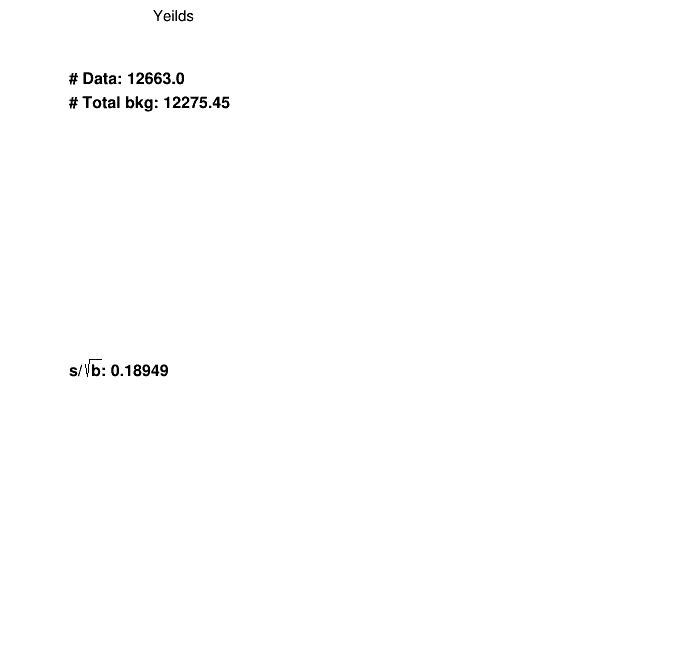

In [8]:
import time
# nbin=int(sys.argv[2])
# part=sys.argv[3]

VERSION = "0903"

ERA="mm17"
nt = 'Beq0'
nbin=20
OUTDIR = 'Outputs/'+CHANNEL+'/Dedicated/'
model_mass = "Zp-2500_CH-345"
key = model_mass
file_postfix = model_mass+'_'+VERSION

print(time.time())
os.system("ls Outputs/mm/Dedicated/")

import matplotlib.pyplot as plt
import seaborn as sns
import ROOT as rt
from collections import defaultdict
# %matplotlib inline
rt.gROOT.SetBatch(rt.kTRUE)
# for key in dic_df_train:
#     if "Zp" in key:
#         tf.debugging.set_log_device_placement(True) -> at cpu, prints many thing
#     if model_mass in key:
#         model = keras.models.load_model('Outputs/mm/model_mm_binary_Zp-2500_CH-3451128')
model = keras.models.load_model(OUTDIR+'/model_binary_'+file_postfix)

Transformer = pickle.load(open(OUTDIR+'/scaler_'+file_postfix+'.pkl','rb'))
# Transformer = pickle.load(open('Outputs/mm/Dedicated/scaler_Zp-2500_CH-345_0903.pkl','rb'))

dic_df_scale={}
dic_df_scale_met_u={}
dic_df_scale_met_d={}
for key2 in dic_df_train:
#             dic_df_scale[key2].append(dic_df_train[key2])       
    dic_df_scale[key2] = Transformer.transform(dic_df_train[key2]) 
    dic_df_scale_met_u[key2] = Transformer.transform(dic_df_met_u[key2]) 
    dic_df_scale_met_d[key2] = Transformer.transform(dic_df_met_d[key2]) 
# predict
dic_predict={}
dic_predict_met_u={}
dic_predict_met_d={}
for key3 in dic_df_scale:
#             if "Zp-" in key3 and not key in key3: # use same scaling used in model training for all masses
#                 continue
    dic_predict[key3] = model.predict(dic_df_scale[key3], batch_size=dic_df_scale[key3].shape[0])
    dic_predict_met_u[key3] = model.predict(dic_df_scale_met_u[key3], batch_size=dic_df_scale_met_u[key3].shape[0])
    dic_predict_met_d[key3] = model.predict(dic_df_scale_met_d[key3], batch_size=dic_df_scale_met_d[key3].shape[0])

# array in y-axis to dataframe
dic_predict_sort={}
dic_predict_met_u_sort={}
dic_predict_met_d_sort={}
for key4 in dic_predict:
    new_df = dic_df[key4].copy(deep=True).reset_index(drop="True")
    new_df_met_u = pd.DataFrame()
    new_df_met_d = pd.DataFrame()
    new_df_met_u["weightmetUp"] = dic_df_met_u_unsort[key4]["weight"].copy(deep=True).reset_index(drop="True")
    new_df_met_d["weightmetDown"] = dic_df_met_d_unsort[key4]["weight"].copy(deep=True).reset_index(drop="True")
    new_df["score"] = dic_predict[key4][:,0]
    new_df_met_u["score"] = dic_predict_met_u[key4][:,0]
    new_df_met_d["score"] = dic_predict_met_d[key4][:,0]     
    dic_predict_sort[key4] = new_df
    dic_predict_met_u_sort[key4] = new_df_met_u
    dic_predict_met_d_sort[key4] = new_df_met_d


#-- implement systematics --#   
os.system("mkdir -p Outputs/"+channel)
os.system("mkdir -p Outputs/"+channel+"/sys")
sys_list = ["puweight", "l1prefiring", "effSF", "topSF"]
# sys_list = ["puweight"]

r = [nbin, 0, 1, "DNN score"]

# draw plot with syst
dic_sys_sqr = draw_with_systematics(dic_predict_sort, sys_list, "score", r, "region_dummy")

hist=HistStack(dic_predict_sort, "score", 'weight', nbin, 0, 1, "DNN score", dic_sys=dic_sys_sqr) 
threshold = 1

c1=hist.draw_hist("Zp-2500_CH-345", ERA, file_name="Outputs/"+channel+"/DNNScore.pdf", blind_from=threshold)     
hist.get_yeilds()
hist.draw_pie(file_name="Outputs/"+channel+"/pie.pdf")    
          


In [9]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn import metrics
def dump_roc(key, y, predict, sample_weight=None, channel=channel, note=""):
    #### get the ROC curves
    fpr = {}
    tpr = {}
    auc1 = {}
    plt.figure(figsize=(10,10))

    fpr, tpr, threshold = roc_curve(y[:,0], predict[:,dic_predict_sort['TT'].columns.get_loc("score")], sample_weight=predict[:,dic_predict_sort['TT'].columns.get_loc("weight")])
    # bug? hotfix
    sorted_index = np.argsort(fpr)
    fpr = np.array(fpr)[sorted_index]
    auc1 = metrics.auc(fpr, tpr)
    plt.plot(tpr,fpr,label='train, auc = %.1f%%'%(auc1*100.))
    
#     # variables' roc
#     for i in range(8):
#         fpr, tpr, threshold = roc_curve(y_train[:,0], x_train[:,i], sample_weight=sample_weight_train)
#         # bug? hotfix
#         sorted_index = np.argsort(fpr)
#         fpr = np.array(fpr)[sorted_index]
#         auc1 = auc(fpr, tpr)
#         plt.plot(tpr,fpr,label=selected_columns[i].replace('_pre', '')+', auc = %.1f%%'%(auc1*100.))
    
#     plt.semilogy()
#     plt.title("roc_"+key, fontsize=18)
#     plt.xlabel("Signal Efficiency", fontsize=18)
#     plt.ylabel("Background Efficiency", fontsize=18)
#     plt.ylim(0.0001,1)
#     plt.grid(True)
#     plt.legend(loc='lower right', prop={'size': 15})
#     plt.savefig("Outputs/"+channel+"/roc_dump_"+key+note+".pdf")
    
    
    return tpr, fpr, auc1

/tmp/ipykernel_5098/2856731590.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(10,10))


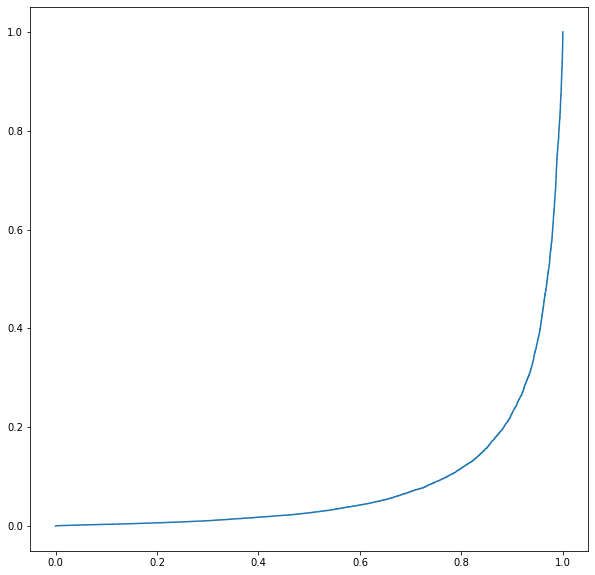

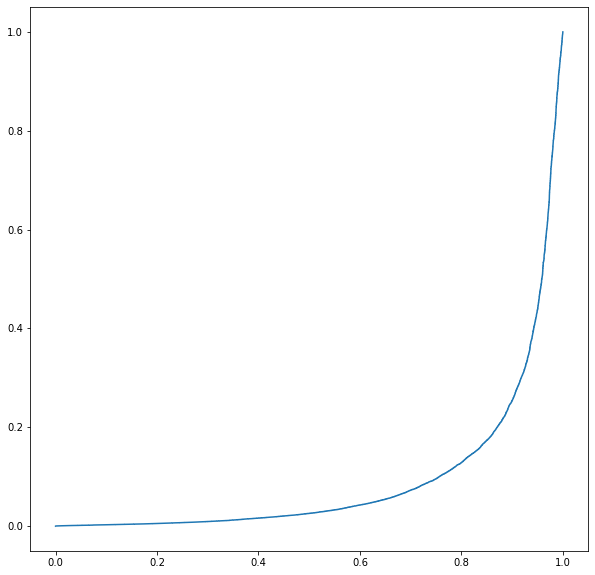

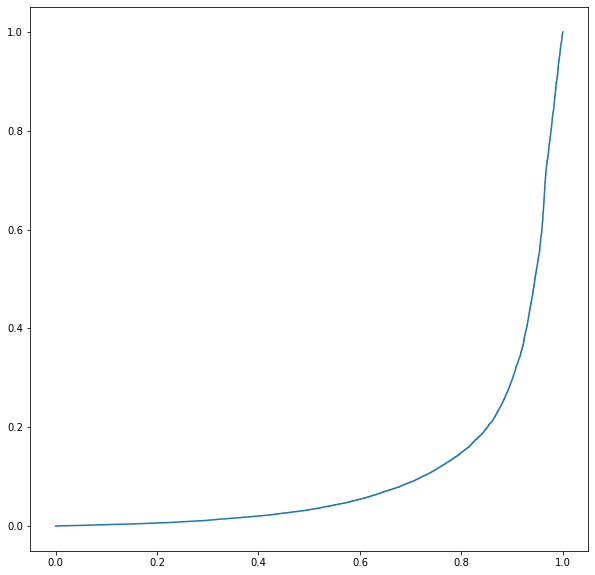

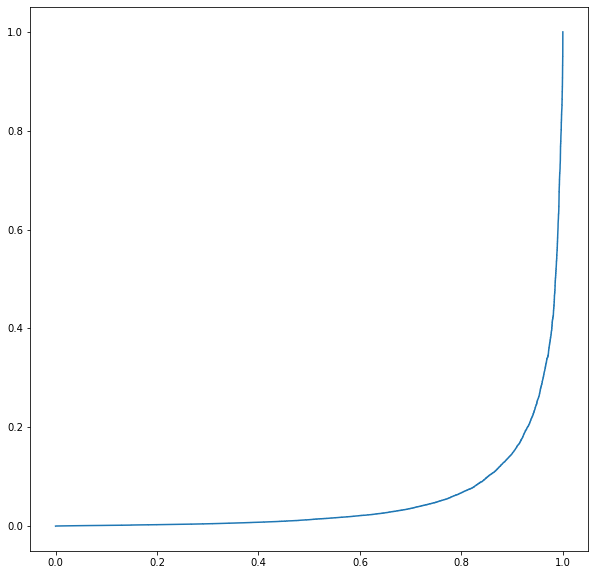

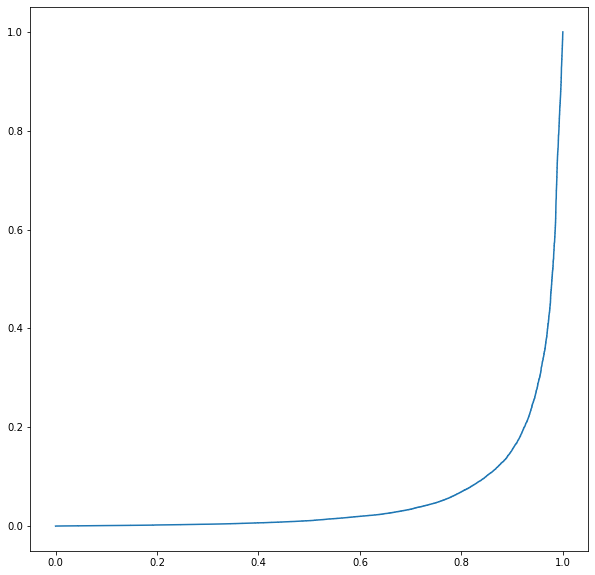

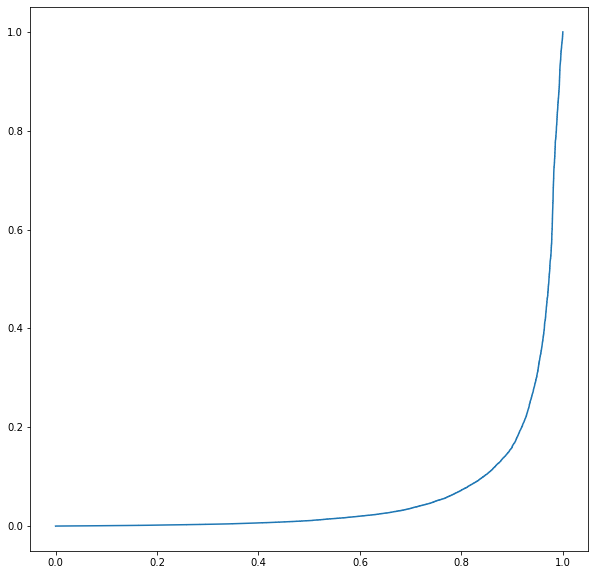

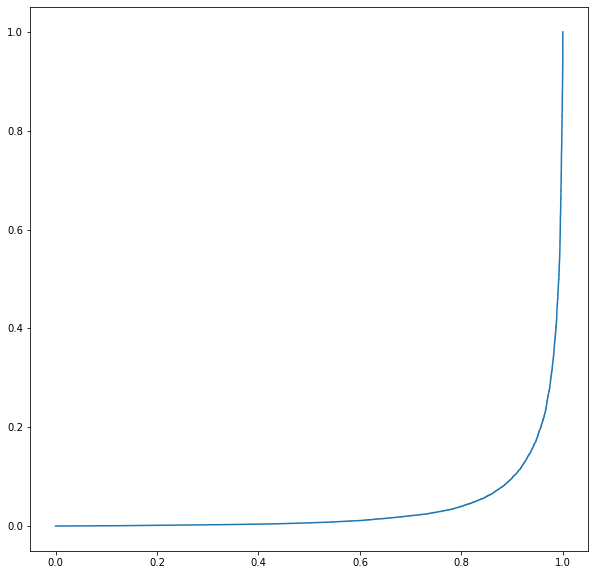

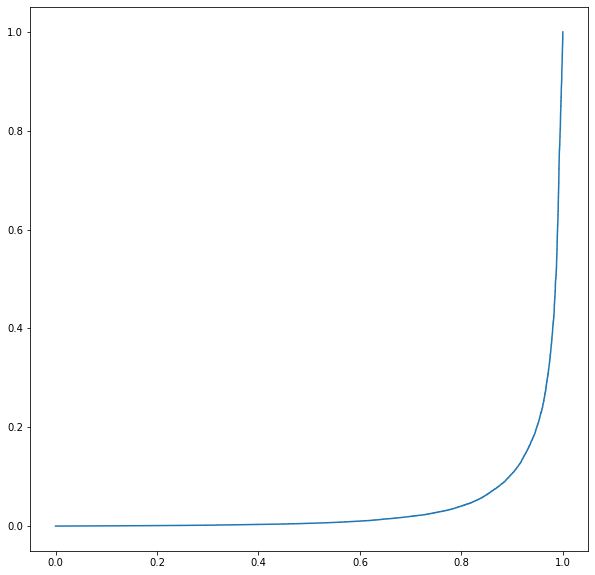

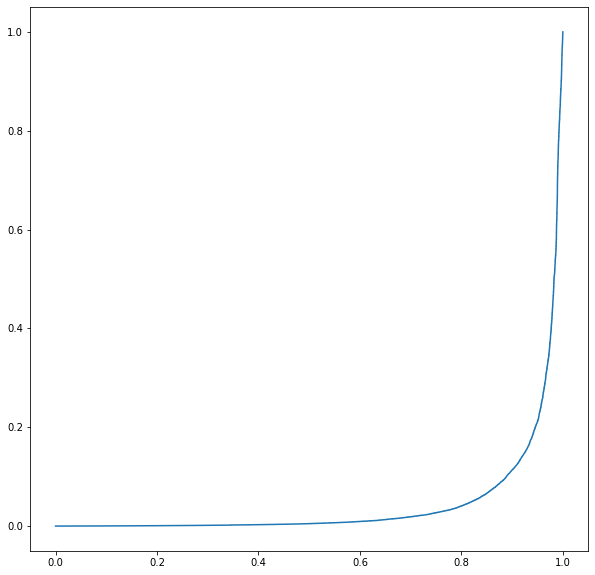

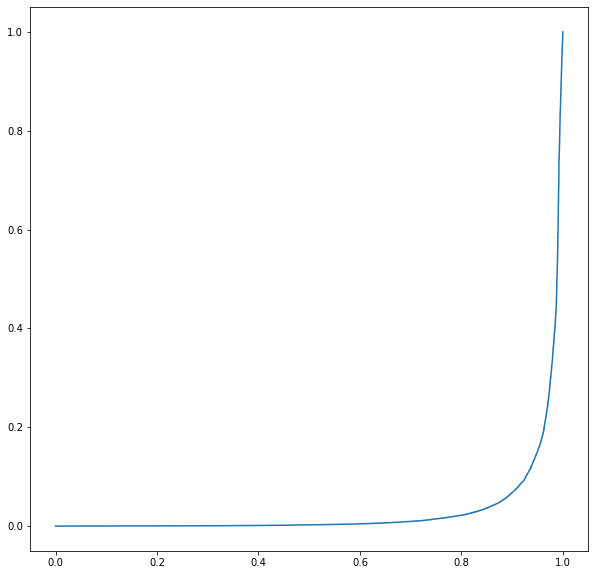

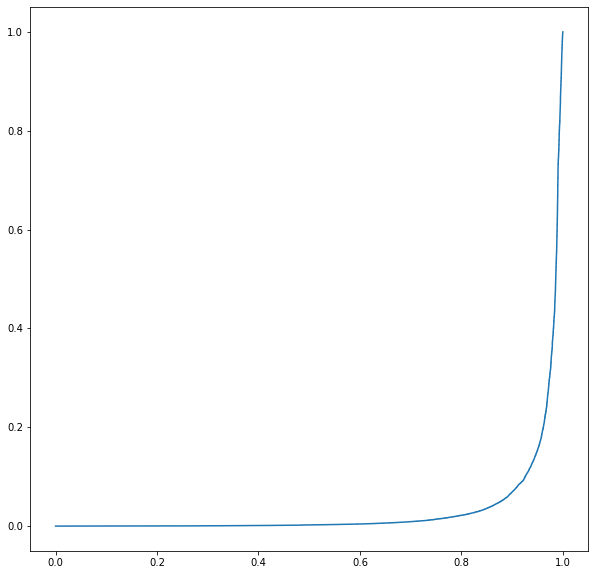

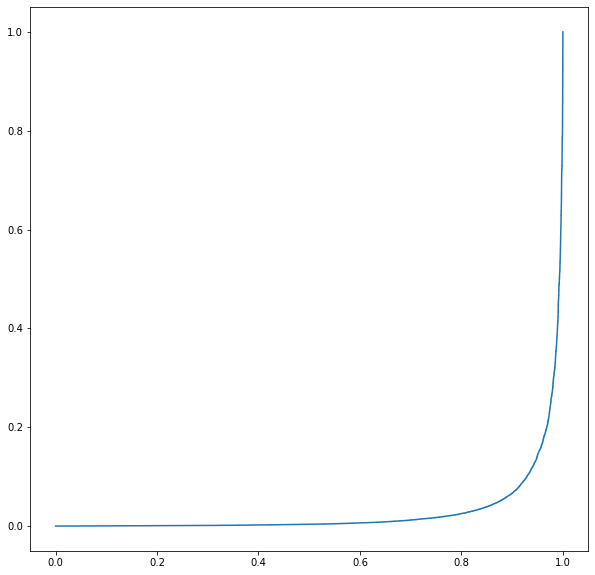

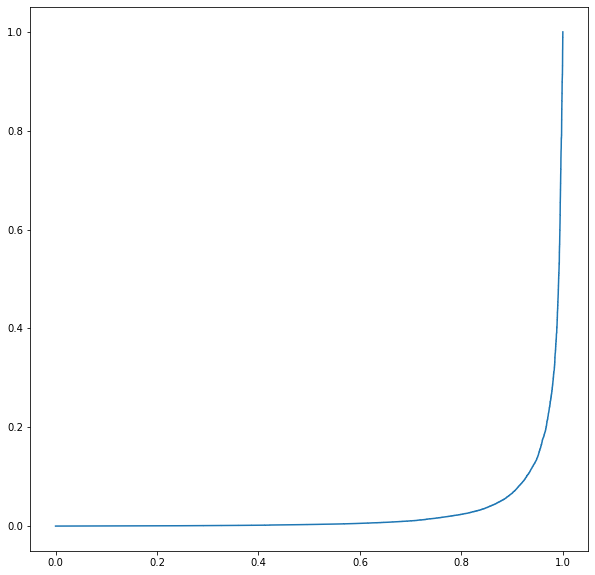

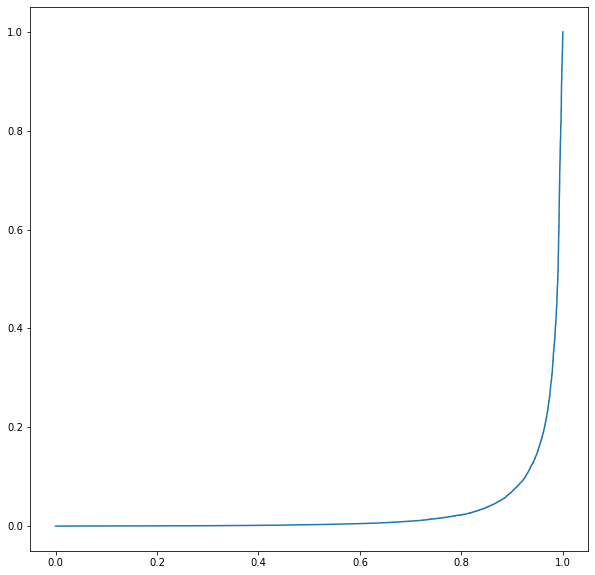

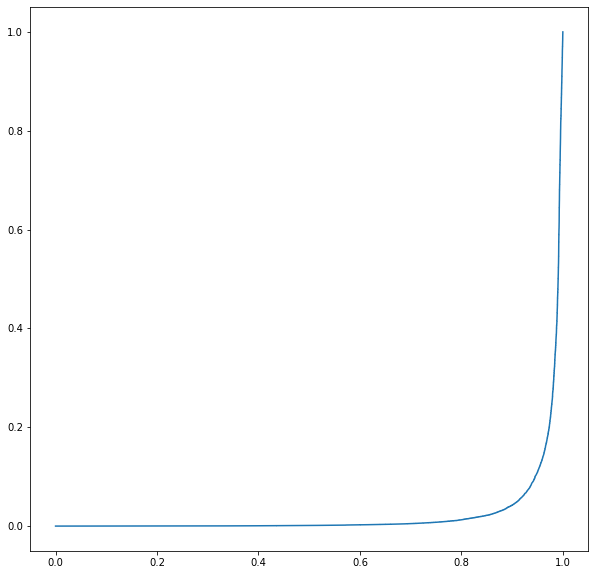

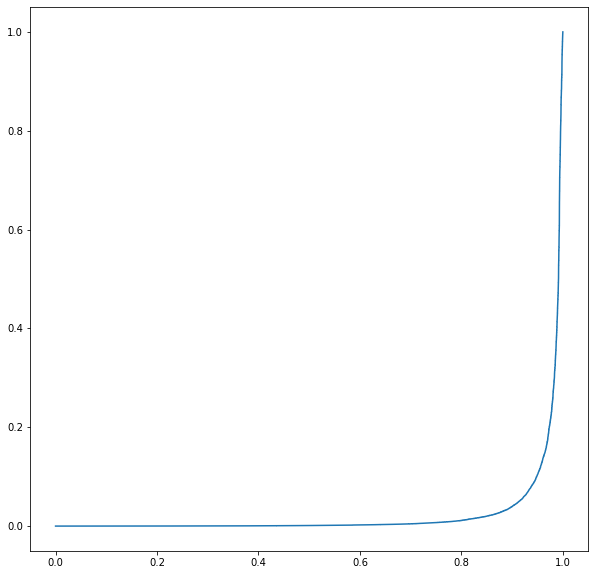

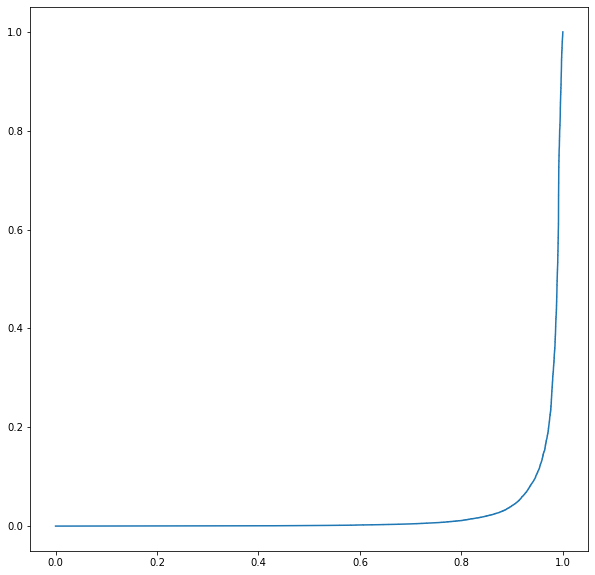

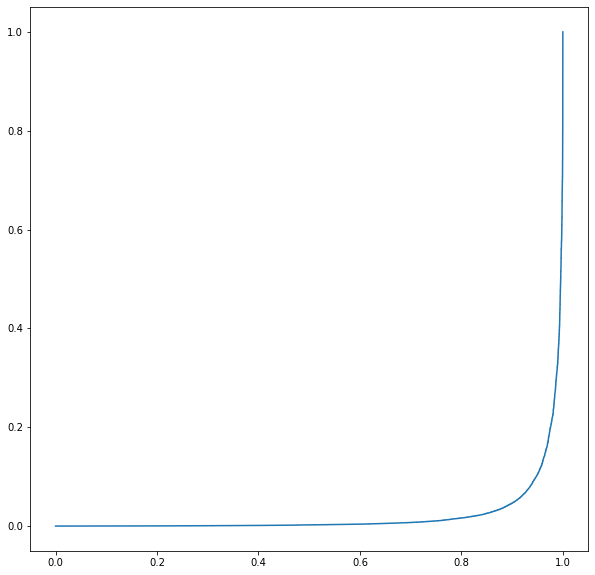

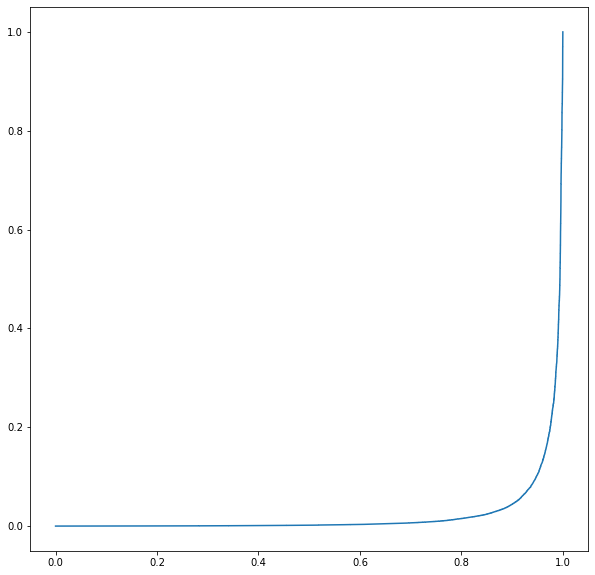

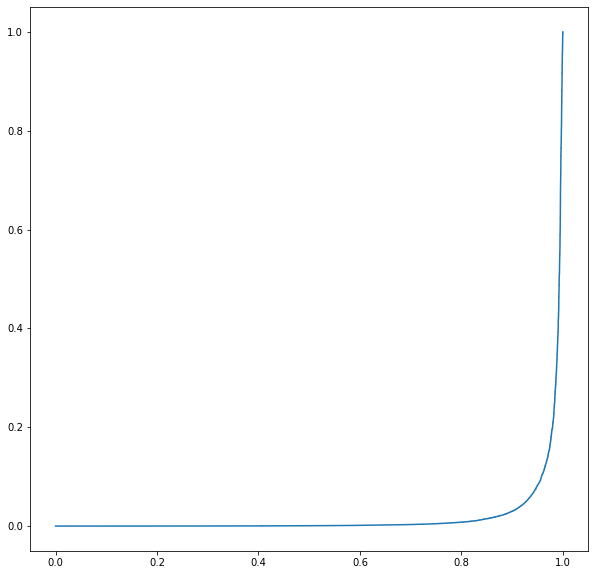

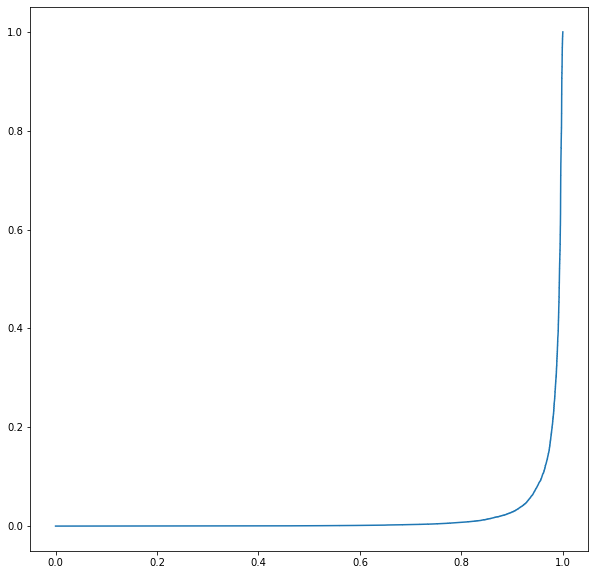

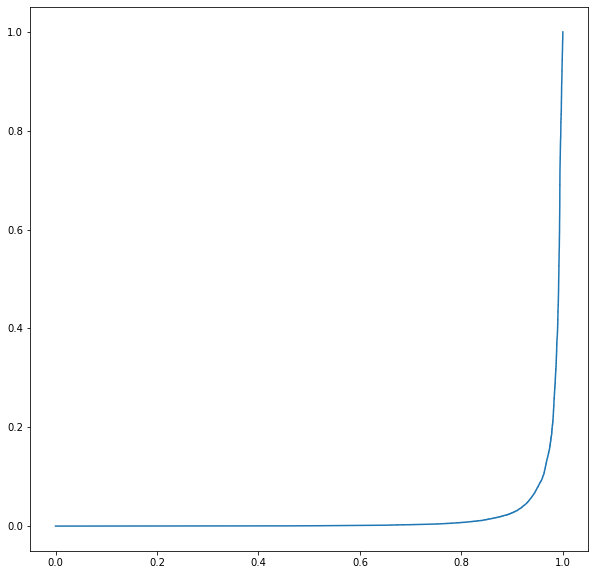

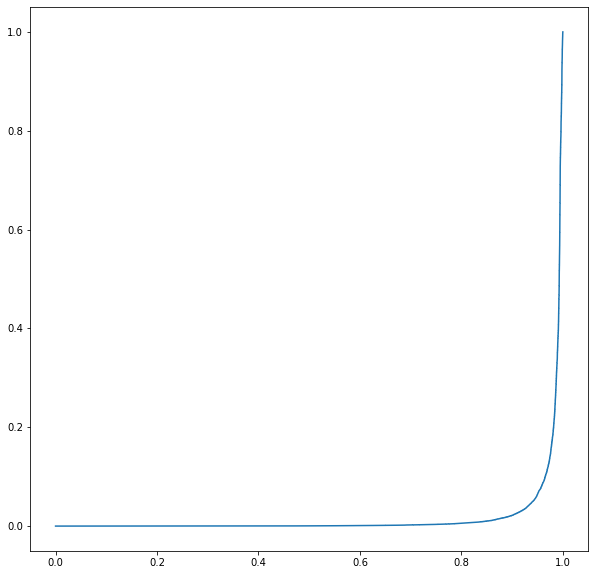

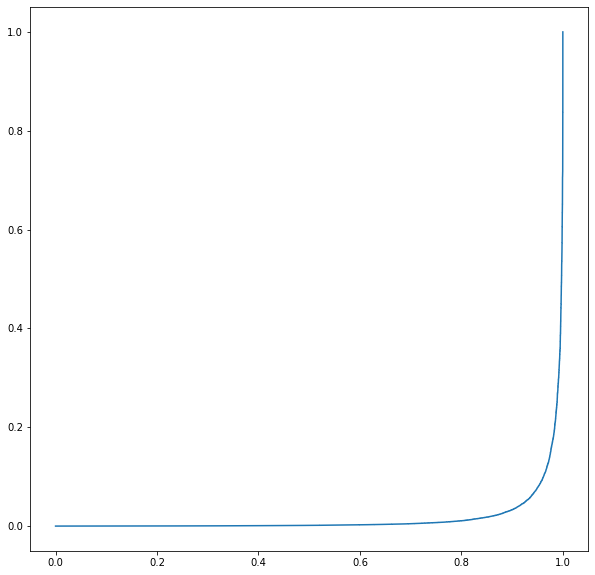

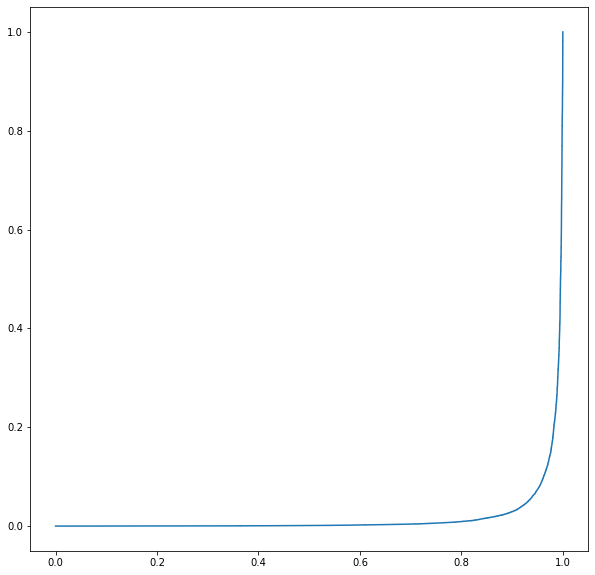

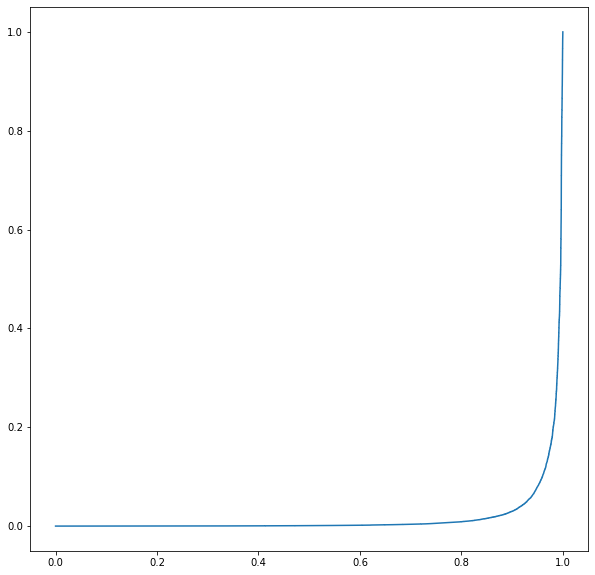

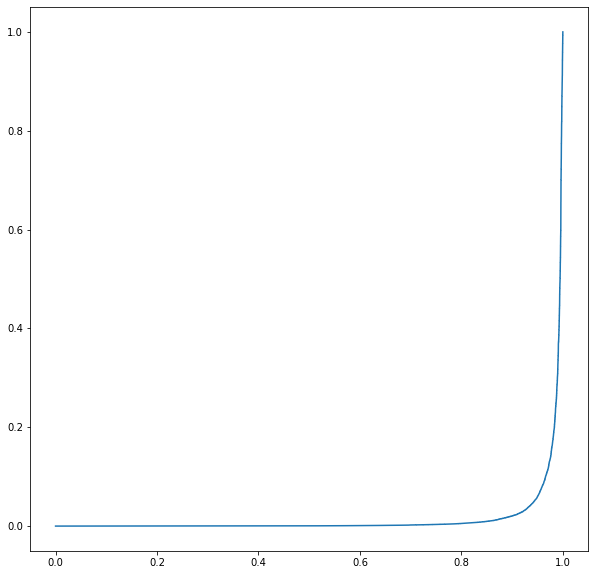

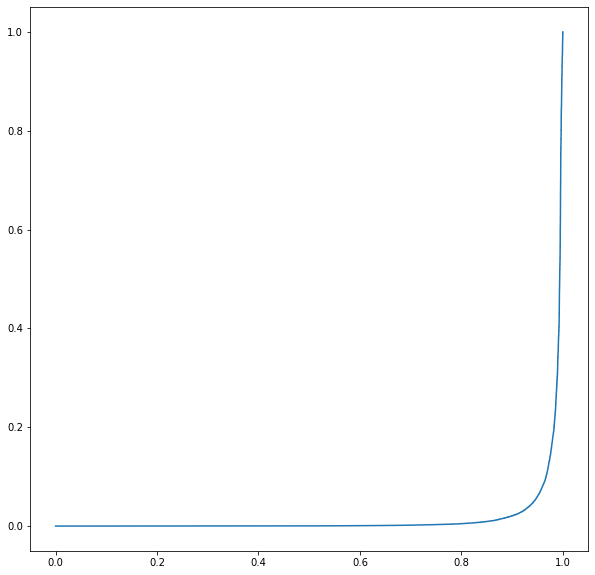

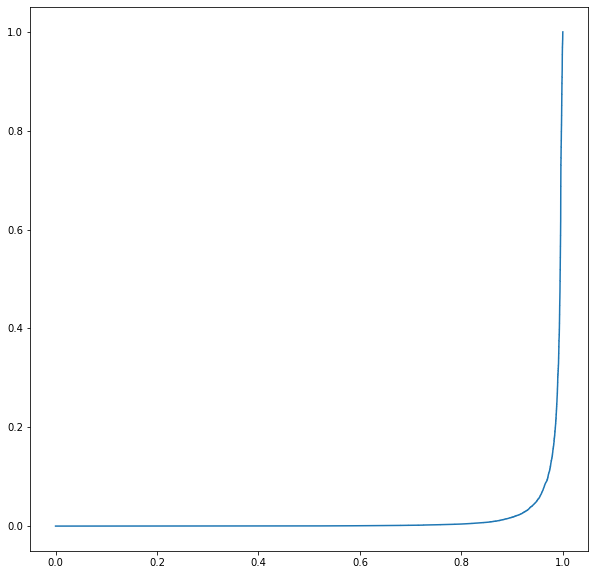

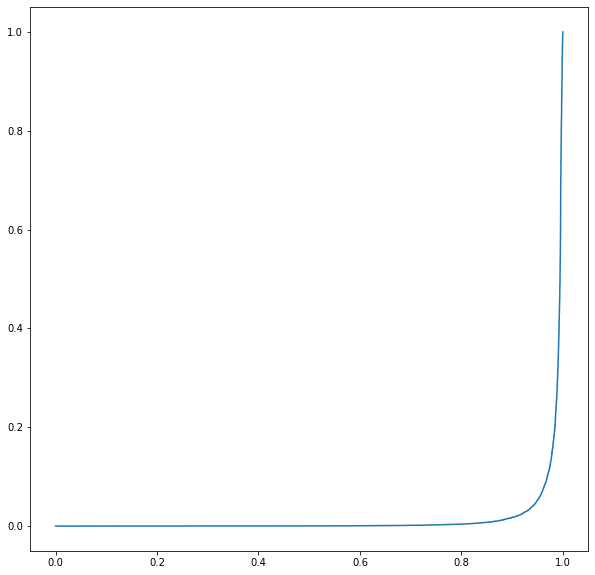

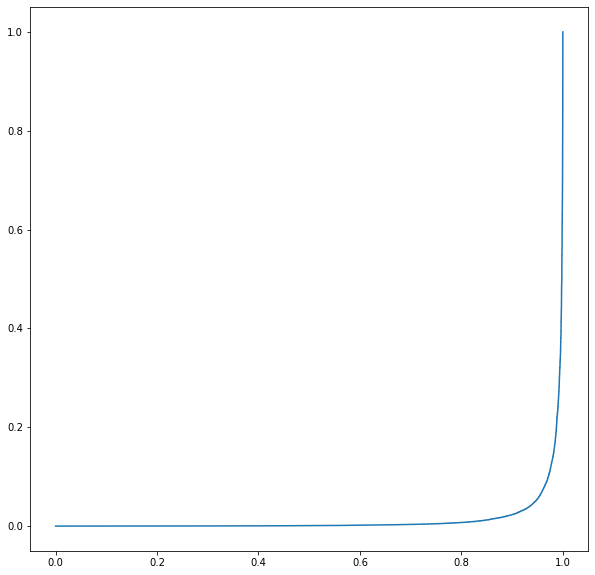

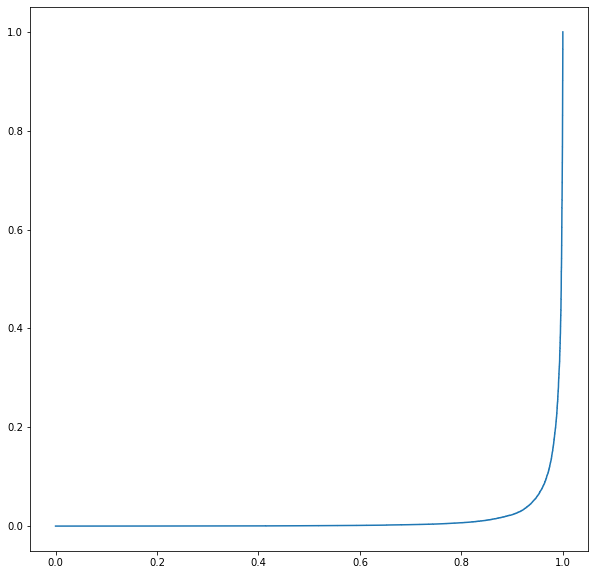

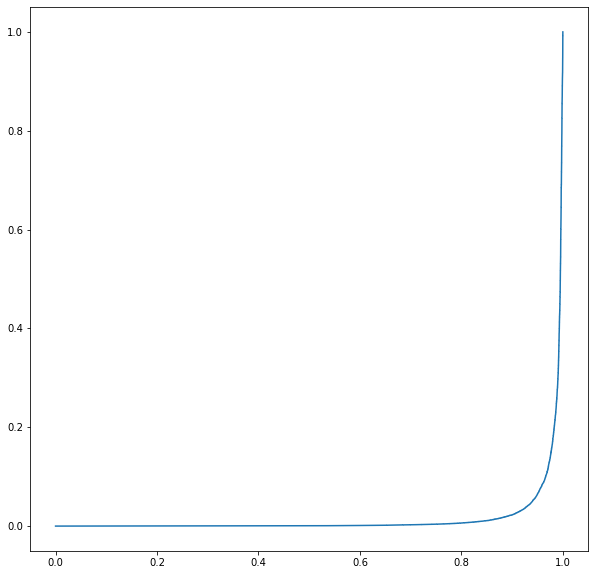

In [10]:
dic_nested_roc = {}
for key in dic_predict_sort:
    if "Zp" in key:
        dic_roc = {}
        x, y = get_xy(key, dic_predict_sort)
        tpr, fpr, auc = dump_roc(key, y, x)
        dic_roc['tpr'] = tpr
        dic_roc['fpr'] = fpr
        dic_roc['auc'] = auc
        dic_nested_roc[key] = dic_roc
with open('Outputs/'+channel+'/nested_dic_roc_modelmass'+model_mass+'.pkl', 'wb') as f:
    pickle.dump(dic_nested_roc, f)        